In [1]:
! nvidia-smi

Sun Aug  7 12:48:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:21:00.0 Off |                  N/A |
|  0%   58C    P8    28W / 350W |      3MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:44:00.0 Off |                  N/A |
| 30%   

In [2]:
%run funcs

cuda:1


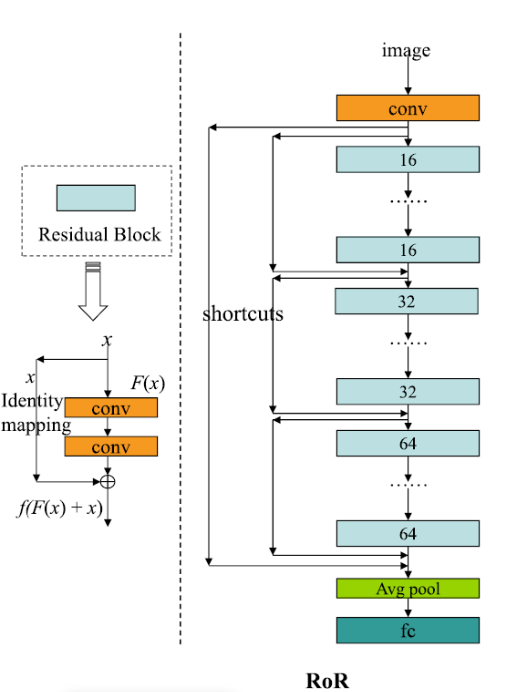

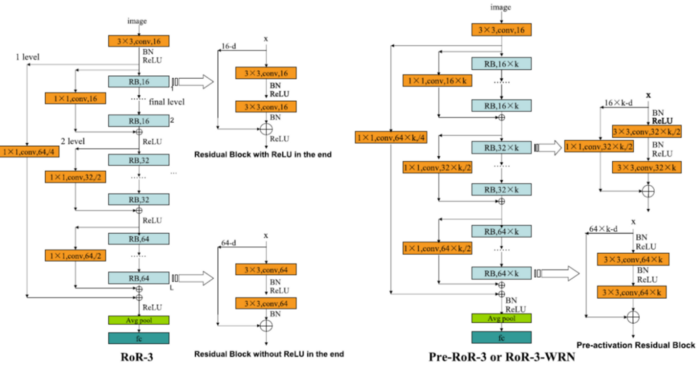

In [180]:
bias_mask = False

class StartBlock(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(            
            torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 ,bias = bias_mask),
            torch.nn.BatchNorm1d(5),
            torch.nn.PReLU())
    def forward(self, inputs):
        return self.net(inputs)
class ResBlock(torch.nn.Module):
    def __init__(self,input_size,power =4):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            #torch.nn.Conv1d(input_size*power, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            #torch.nn.BatchNorm1d(input_size*power),
            #torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power, input_size,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU())
    def forward(self, inputs):
        return  self.module(inputs) + inputs        
class ResBlock_conv(torch.nn.Module):
    def __init__(self,input_size,power =4):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power, input_size,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU())
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1), #bias =  bias_mask,
            #torch.nn.PReLU()
        )
    def forward(self, inputs):
        return  self.module(inputs) + inputs  
    
class BigResBlock(torch.nn.Module):
    def __init__(self,input_size, power = 4):
        super().__init__()
        self.big_module = torch.nn.Sequential(
            ResBlock(input_size, power ),
            ResBlock(input_size, power),
            ResBlock(input_size, power) )
        self.conv =  torch.nn.Conv1d(input_size, input_size, kernel_size =1) #bias =  bias_mask,
        self.trans_module = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size*2, kernel_size=3, stride=2,padding=1 , bias = False),
            torch.nn.BatchNorm1d(num_features=input_size*2),
            torch.nn.PReLU() )        
    def forward(self, inputs):
        outp = self.trans_module(self.big_module(inputs) + self.conv(inputs))
        #outp = outp)
        return  outp
    
class FCBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(160,160),
            torch.nn.BatchNorm1d(160),
            torch.nn.PReLU(),
            torch.nn.Linear(160,160),
            torch.nn.BatchNorm1d(160),
            torch.nn.PReLU(),
            torch.nn.Linear(160 ,2))
    def forward(self, inputs):
        return self.net(inputs)
    
class MyNet(torch.nn.Module):
    def __init__(self,power = 4):
        super().__init__()
        self.start = StartBlock()
        self.backbone =  torch.nn.Sequential( 
            BigResBlock(5, power),
            BigResBlock(10, power),
            BigResBlock(20, power))
        self.FC = FCBlock()
        self.conv = torch.nn.Conv1d(5,40,kernel_size = 8, stride = 8)
    def forward(self, inputs):
        outp = self.start(inputs)
        outp = self.backbone(outp) + self.conv(outp) 
        outp = torch.nn.Flatten()(outp)
        outp = self.FC(outp)
        return outp
          

In [166]:
a = torch.ones((512,5 ,32))
net_MC_data = MyNet()
print(net_MC_data(a).shape )
sum(p.numel() for p in net_MC_data.parameters()   ) 

torch.Size([512, 2])


96931

Num of sub-epochs in Epoch =  26 

Indeed Epoch =  1     Indeed Epoch =  2     Indeed Epoch =  3     Indeed Epoch =  4     Indeed Epoch =  5     Indeed Epoch =  6     Indeed Epoch =  7     Indeed Epoch =  8     Indeed Epoch =  9     Indeed Epoch =  10     Indeed Epoch =  11     Indeed Epoch =  12     Indeed Epoch =  13     Indeed Epoch =  14     Indeed Epoch =  15     Indeed Epoch =  16     Indeed Epoch =  17     Indeed Epoch =  18     Indeed Epoch =  19     Indeed Epoch =  20     Indeed Epoch =  21     Indeed Epoch =  22     Indeed Epoch =  23     Indeed Epoch =  24     Indeed Epoch =  25     Indeed Epoch =  26     Indeed Epoch =  27     Indeed Epoch =  28     Indeed Epoch =  29     Indeed Epoch =  30     

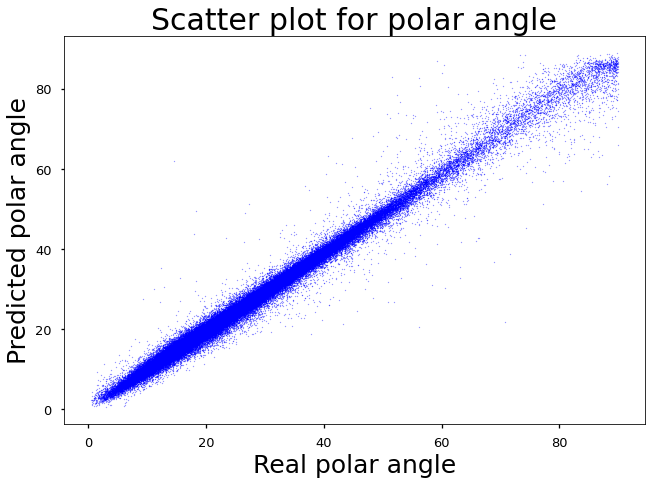

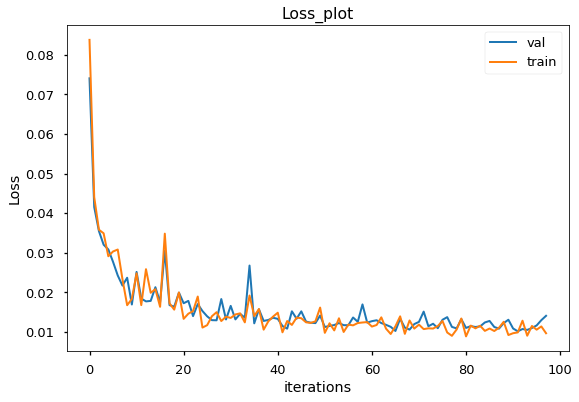

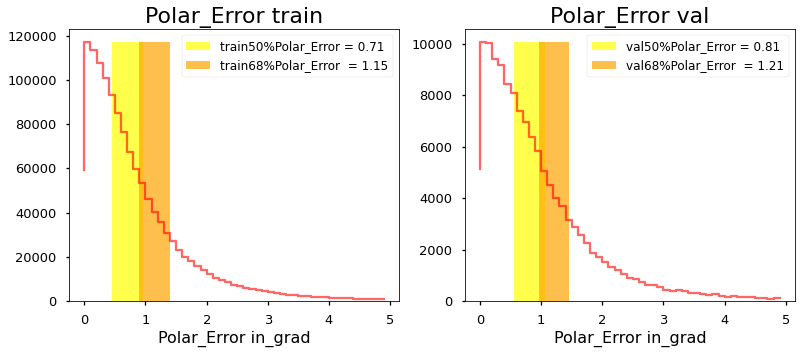

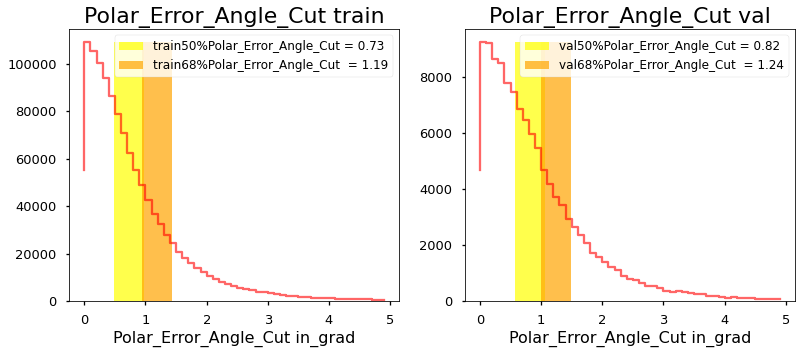

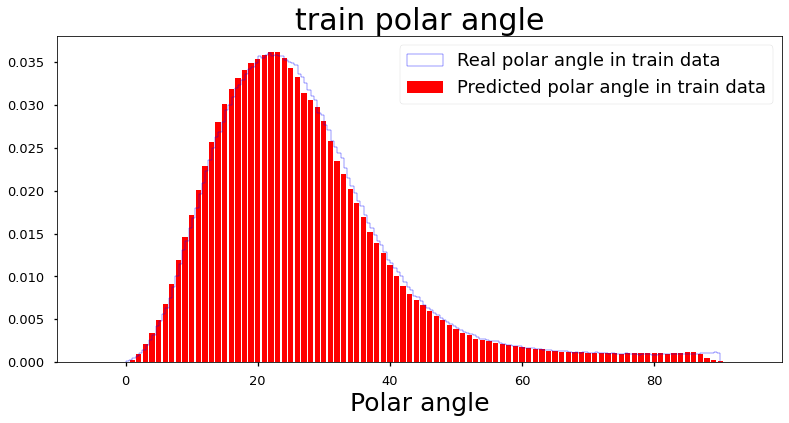

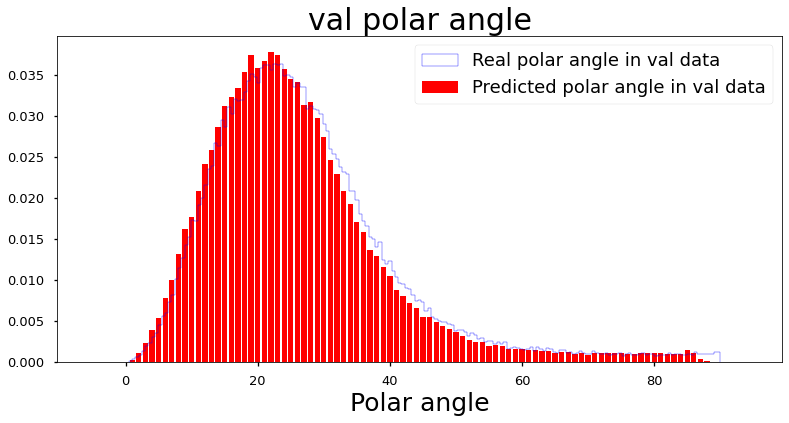

In [167]:
model = MyNet().to(device)
opt = torch.optim.Adam(model.parameters(),lr=2e-3)

sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.975)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[6,12,18,24,30], gamma=1) 
loss_lists, polar_hists ,polar_error =fitting(model, sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_RoR_1",
                                                                       epochs_num = 30, batch_size =128)

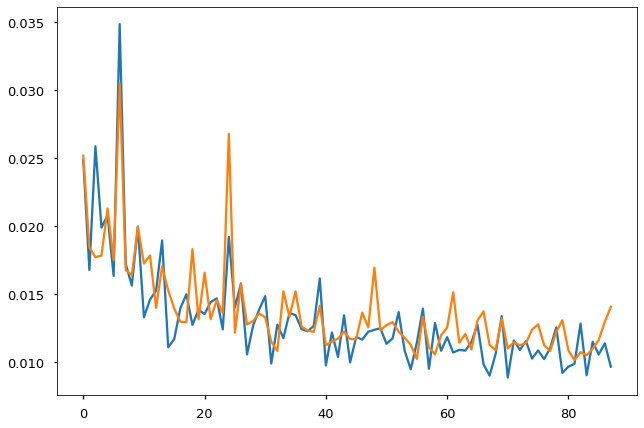

In [170]:
plt.plot(loss_lists[0][10:]);plt.plot(loss_lists[1][10:])

# power = 2

torch.Size([512, 2])
77611
Num of sub-epochs in Epoch =  26 

Indeed Epoch =  1     Indeed Epoch =  2     Indeed Epoch =  3     Indeed Epoch =  4     Indeed Epoch =  5     Indeed Epoch =  6     Indeed Epoch =  7     Indeed Epoch =  8     Indeed Epoch =  9     Indeed Epoch =  10     Indeed Epoch =  11     Indeed Epoch =  12     Indeed Epoch =  13     Indeed Epoch =  14     Indeed Epoch =  15     Indeed Epoch =  16     Indeed Epoch =  17     Indeed Epoch =  18     Indeed Epoch =  19     Indeed Epoch =  20     Indeed Epoch =  21     Indeed Epoch =  22     Indeed Epoch =  23     Indeed Epoch =  24     Indeed Epoch =  25     Indeed Epoch =  26     Indeed Epoch =  27     Indeed Epoch =  28     Indeed Epoch =  29     Indeed Epoch =  30     

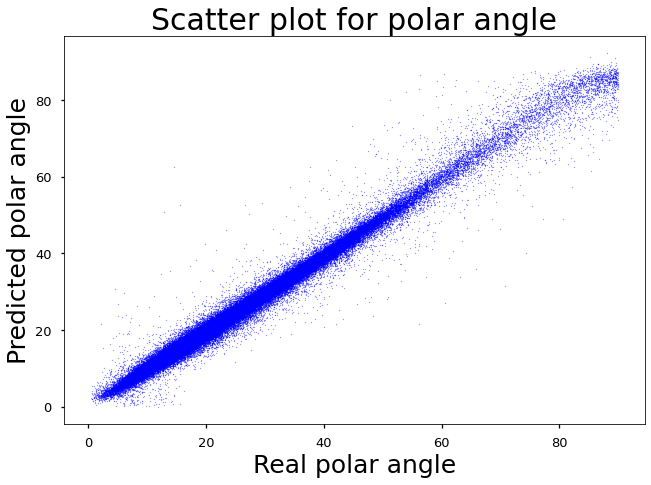

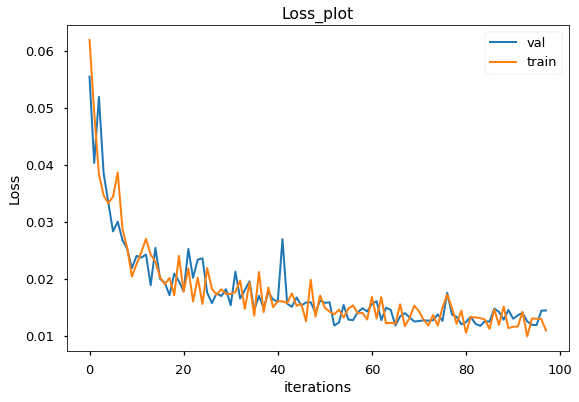

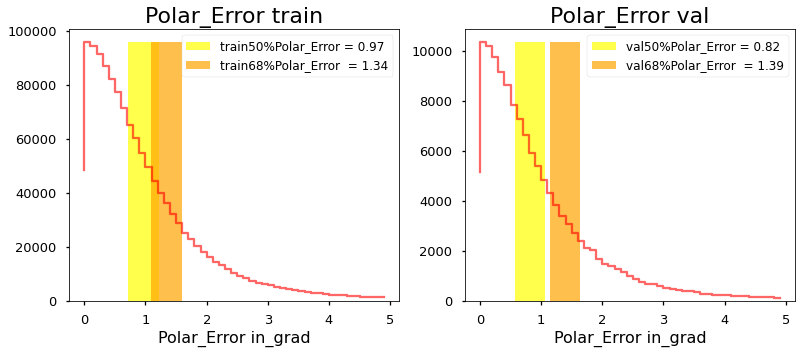

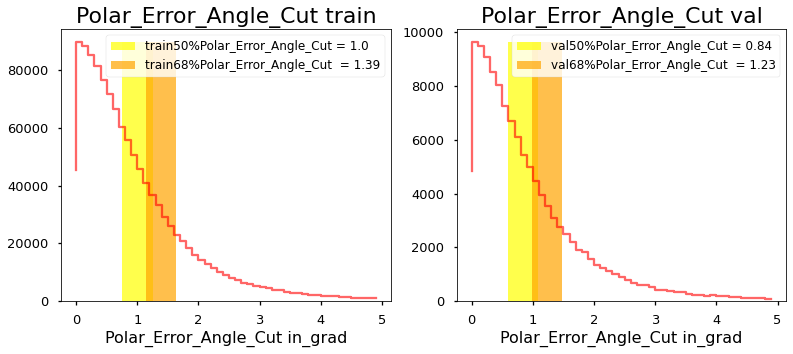

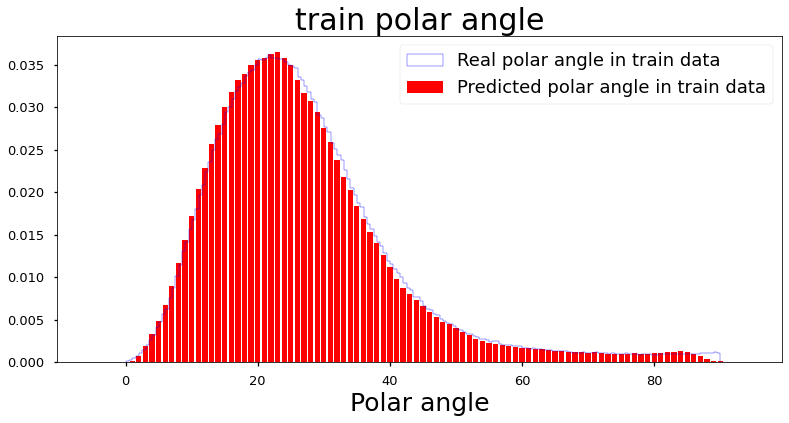

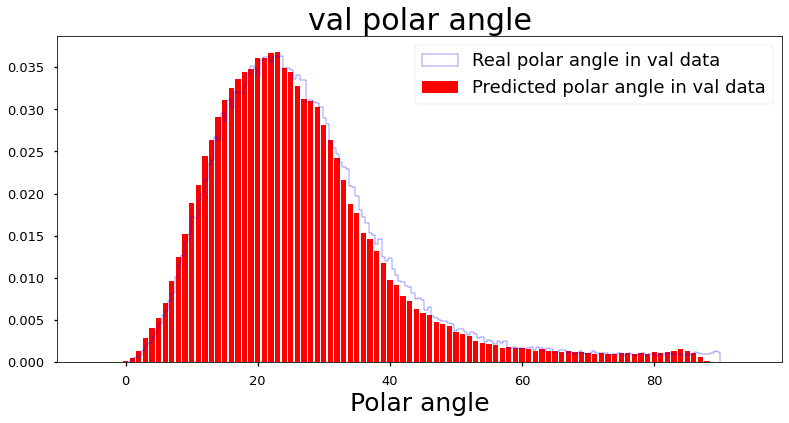

In [183]:
model = MyNet(power = 2).to(device)
a = torch.ones((512,5 ,32)).to(device)
print(model(a).shape )
print(sum(p.numel() for p in model.parameters())  )  
opt = torch.optim.Adam(model.parameters(),lr=2e-3)

sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.975)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[6,12,18,24,30], gamma=1) 
loss_lists, polar_hists ,polar_error =fitting(model, sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_RoR_power2",
                                                                       epochs_num = 30, batch_size =128)

Num of sub-epochs in Epoch =  26 

Indeed Epoch =  1     Indeed Epoch =  2     Indeed Epoch =  3     Indeed Epoch =  4     Indeed Epoch =  5     Indeed Epoch =  6     Indeed Epoch =  7     Indeed Epoch =  8     Indeed Epoch =  9     Indeed Epoch =  10     

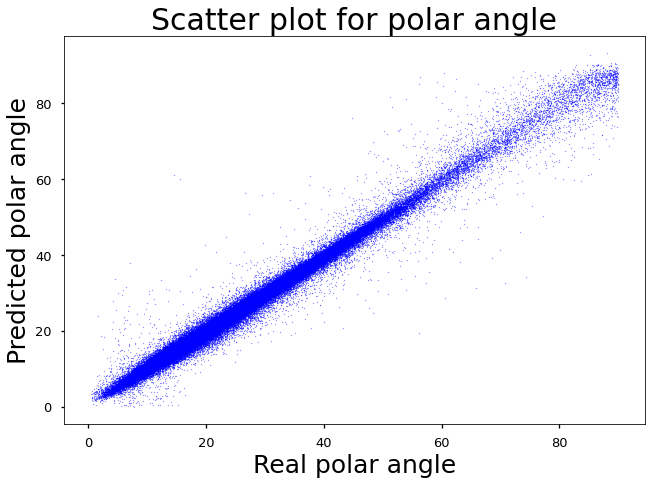

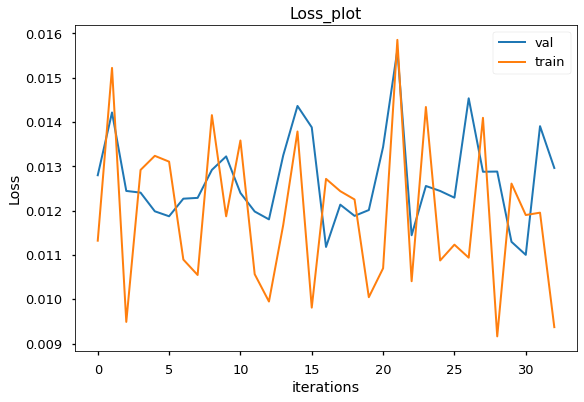

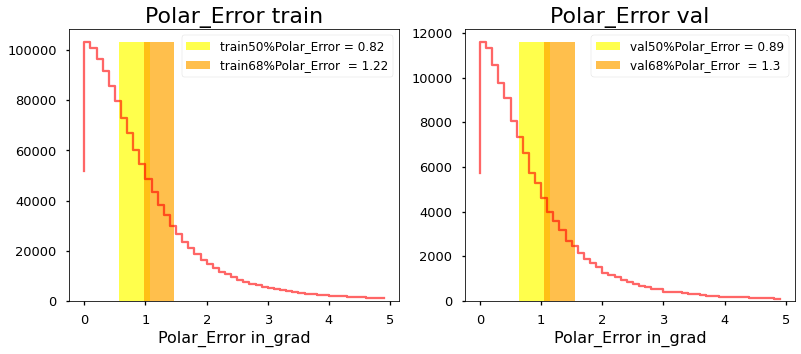

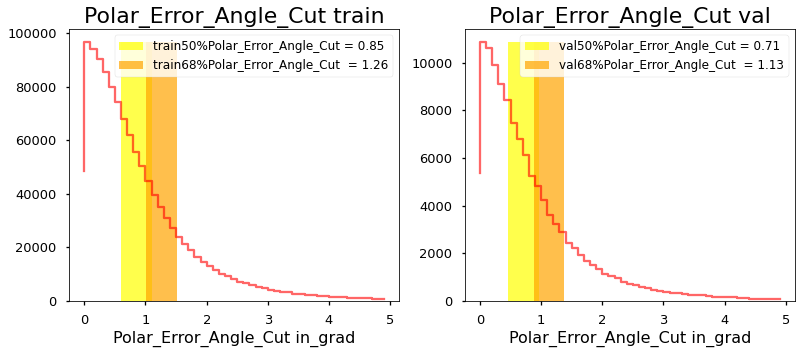

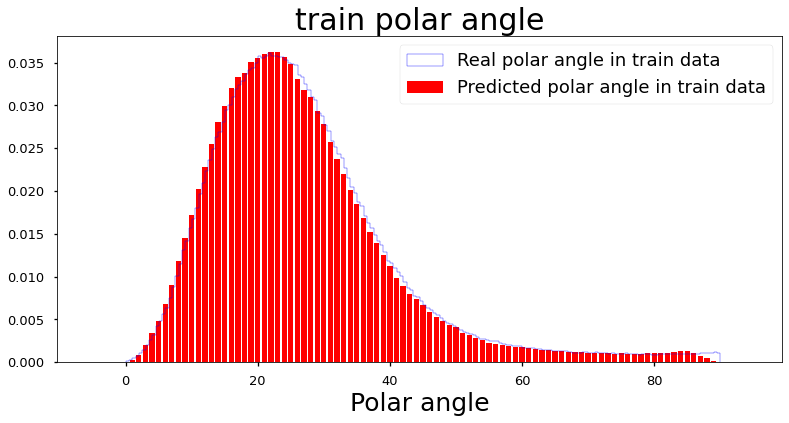

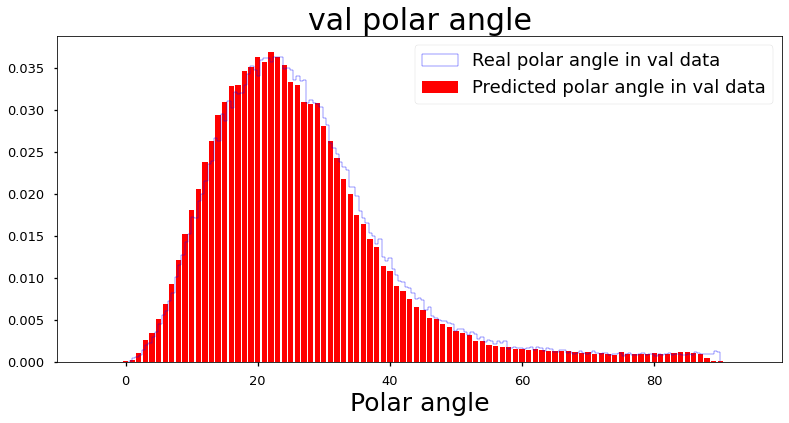

In [184]:
loss_lists, polar_hists ,polar_error =fitting(model, sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_RoR_power2",
                                                                       epochs_num = 10, batch_size =128)

# 3 convolutions in row

In [171]:
class ResBlock(torch.nn.Module):
    def __init__(self,input_size,power =4):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power, input_size,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU())
    def forward(self, inputs):
        return  self.module(inputs) + inputs
    
a = torch.ones((512,5 ,32))
net_MC_data_2 = MyNet()
print(net_MC_data_2(a).shape )
sum(p.numel() for p in net_MC_data_2.parameters()   ) 

torch.Size([512, 2])


173380

173380
Num of sub-epochs in Epoch =  26 

Indeed Epoch =  1     Indeed Epoch =  2     Indeed Epoch =  3     Indeed Epoch =  4     Indeed Epoch =  5     Indeed Epoch =  6     Indeed Epoch =  7     Indeed Epoch =  8     Indeed Epoch =  9     Indeed Epoch =  10     Indeed Epoch =  11     Indeed Epoch =  12     Indeed Epoch =  13     Indeed Epoch =  14     Indeed Epoch =  15     Indeed Epoch =  16     Indeed Epoch =  17     Indeed Epoch =  18     Indeed Epoch =  19     Indeed Epoch =  20     Indeed Epoch =  21     Indeed Epoch =  22     Indeed Epoch =  23     Indeed Epoch =  24     Indeed Epoch =  25     Indeed Epoch =  26     Indeed Epoch =  27     Indeed Epoch =  28     Indeed Epoch =  29     Indeed Epoch =  30     

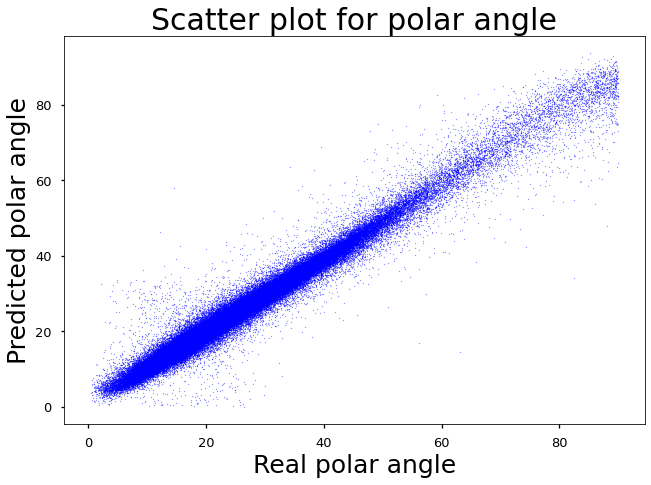

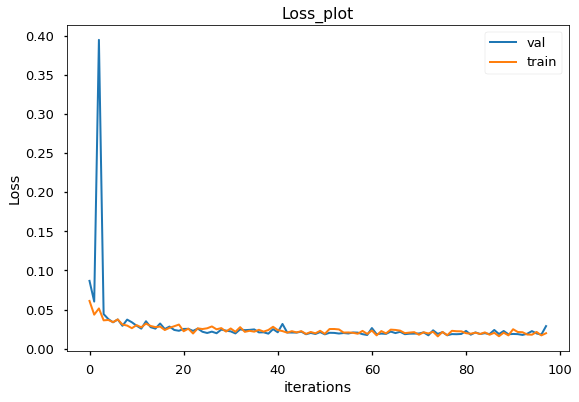

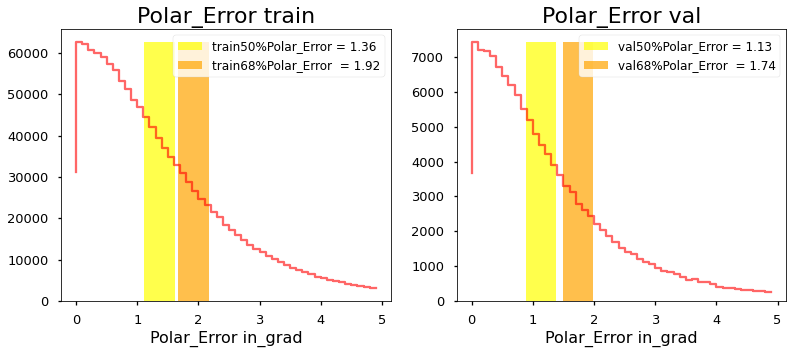

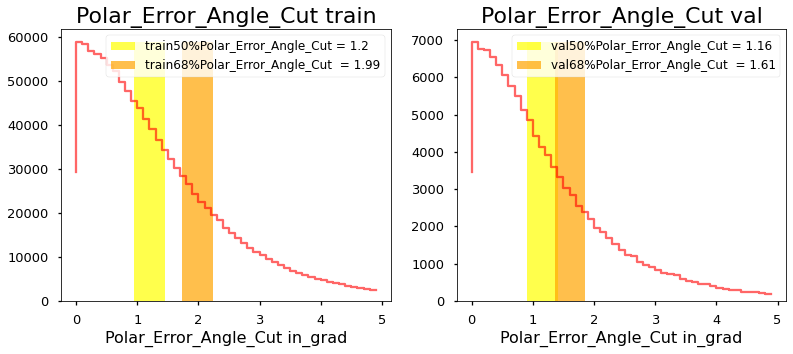

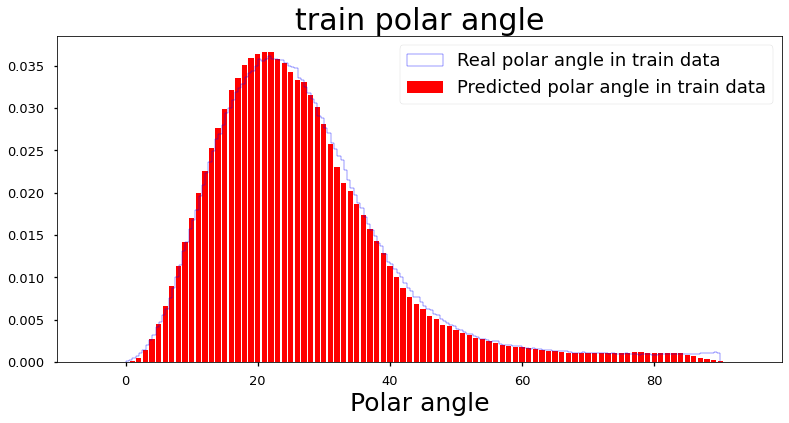

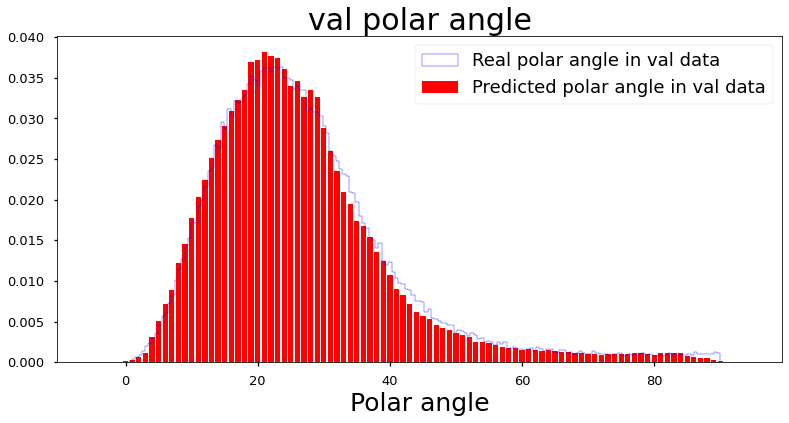

In [178]:
model = MyNet().to(device)
print(sum(p.numel() for p in model.parameters()   )) 
opt = torch.optim.Adam(model.parameters(),lr=4e-3)

sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.975)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[6,12,18,24,30], gamma=1) 
loss_lists, polar_hists ,polar_error =fitting(model, sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_RoR_2",
                                                                       epochs_num = 30, batch_size =128)

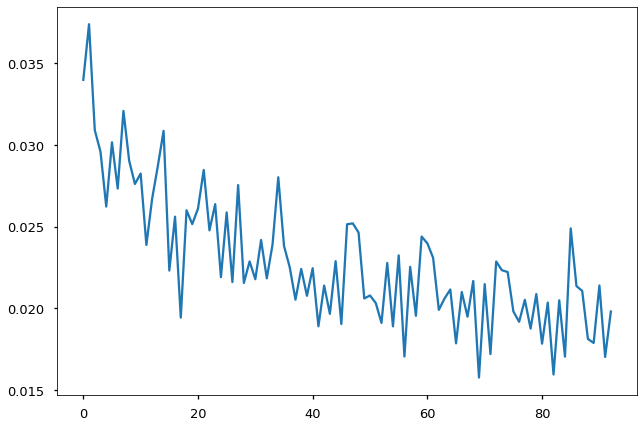

In [179]:
plt.plot(loss_lists[0][5:])#;plt.plot(loss_lists[1][10:])

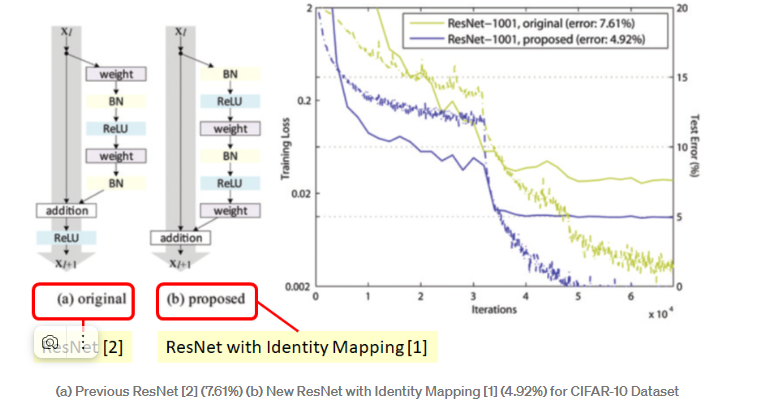